# ***Proposal for Predictive Heart Disease Model*** - Group 63

# ***Introduction***

Heart disease is predominantly characterized by cholesterol plaques that fill and narrow the arteries, preventing normal blood flow. With the help of data science tools and algorithms, we will attempt to classify whether or not someone has heart disease through some common factors.

The question we will try to answer is: given the factors of `age`, cholesterol `(chol)`, maximum heart rate achieved `(thalach)`, and resting blood pressure `(trestbps)`, predict if an individual has heart disease.
The dataset we chose is the heart disease dataset from the UCI Machine Learning Repository, specifically the `processed.cleveland.data` dataset. The dataset contains 14 attributes, including the attributes listed above, and a "goal" field (`num`) which distinguishes if the respective patient has heart disease.

# ***Preliminary exploratory data analysis***

`processed.cleveland.data` was first loaded from the web. The column `num` was then mutated to create `if_hd`, containing if the individual has heart disease (`yes` or `no`). The data was then selected to contain the predictors (`age`, `chol`, `thalach`, `trestbps`) and `if_hd`. Finally, training/ testing sets were created. 

Using the training dataset:

Table one was made to indicate how much data, and of what type (with/ without heart disease), we have to fit our model. The data amount could imply the quality of our model.

Table two contains the mean, min, and max values for each predictor. This, along with the graph, indicate the distribution of each predictor. As well as this, the graph clues into potential trends; high `age`, `chol`, and `trestbps`, as well as low `thalach`, seem associated with heart disease. 

In [1]:
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

In [2]:
#Read, Clean, and Wrangle Data
cleveland_clean <- read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data",
                            col_names=c("age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", "thalach", "exang", "oldpeak", "slope", "ca", "thal", "num")) |>
                    mutate(if_hd = as.character(num)) |>
                    select(age, chol, trestbps, thalach, if_hd)

cleveland_clean["if_hd"][cleveland_clean["if_hd"] == 0, na.rm=TRUE] <- "No"
cleveland_clean["if_hd"][cleveland_clean["if_hd"] != "No", na.rm=TRUE] <- "Yes"

cleveland_clean

Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): ca, thal
dbl (12): age, sex, cp, trestbps, chol, fbs, restecg, thalach, exang, oldpea...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


age,chol,trestbps,thalach,if_hd
<dbl>,<dbl>,<dbl>,<dbl>,<chr>
63,233,145,150,No
67,286,160,108,Yes
67,229,120,129,Yes
⋮,⋮,⋮,⋮,⋮
57,131,130,115,Yes
57,236,130,174,Yes
38,175,138,173,No


In [3]:
#Create Training Set and Testing Set
set.seed(6969)

data_split <- initial_split(cleveland_clean, prop = 0.75, strata = if_hd)
cleveland_train <- training(data_split)  
cleveland_test <- testing(data_split)

In [4]:
#Find Mean Values
cleveland_mean <- cleveland_train |>
    select(-if_hd) |>
    map_df(mean, na.rm=TRUE) |>
    pivot_longer(cols= age:thalach,
                names_to= "predictor", 
                values_to = "mean")

#Find Max Values
cleveland_max <- cleveland_train |>
    select(-if_hd) |>
    map_df(max, na.rm=TRUE)|>
    pivot_longer(cols= age:thalach,
                names_to= "predictor", 
                values_to = "max")

#Find Min Values
cleveland_min <- cleveland_train |>
    select(-if_hd) |>
    map_df(min, na.rm=TRUE) |>
    pivot_longer(cols= age:thalach,
                names_to= "predictor", 
                values_to = "min")

#Number of NAs
training_count <- count(cleveland_train)
NA_training <- cleveland_train |> 
    na.omit() |>
    count()
na <- training_count - NA_training

colnames(na) <- paste0("NAs")

#How many values have/ don't have heart disease, and total number of data values
cleveland_yesvsno <- cleveland_train |>
    group_by(if_hd) |>
    summarize(n=n())|>
    pivot_wider(names_from = if_hd, values_from = n) |>
    mutate(total_data = Yes + No)

colnames(cleveland_yesvsno) <- paste0(list("with_hd", "without_hd", "total_data"))

#Merging of above data into two tables for easier visualization
cleveland_count <- Reduce(merge, list(cleveland_yesvsno, na))
cleveland_count

cleveland_mmm <- Reduce(merge, list(cleveland_mean, cleveland_max, cleveland_min))
cleveland_mmm

with_hd,without_hd,total_data,NAs
<int>,<int>,<int>,<int>
123,104,227,0


predictor,mean,max,min
<chr>,<dbl>,<dbl>,<dbl>
age,54.13656,76,29
chol,247.66520,564,126
thalach,149.33480,202,71
trestbps,132.10573,200,94


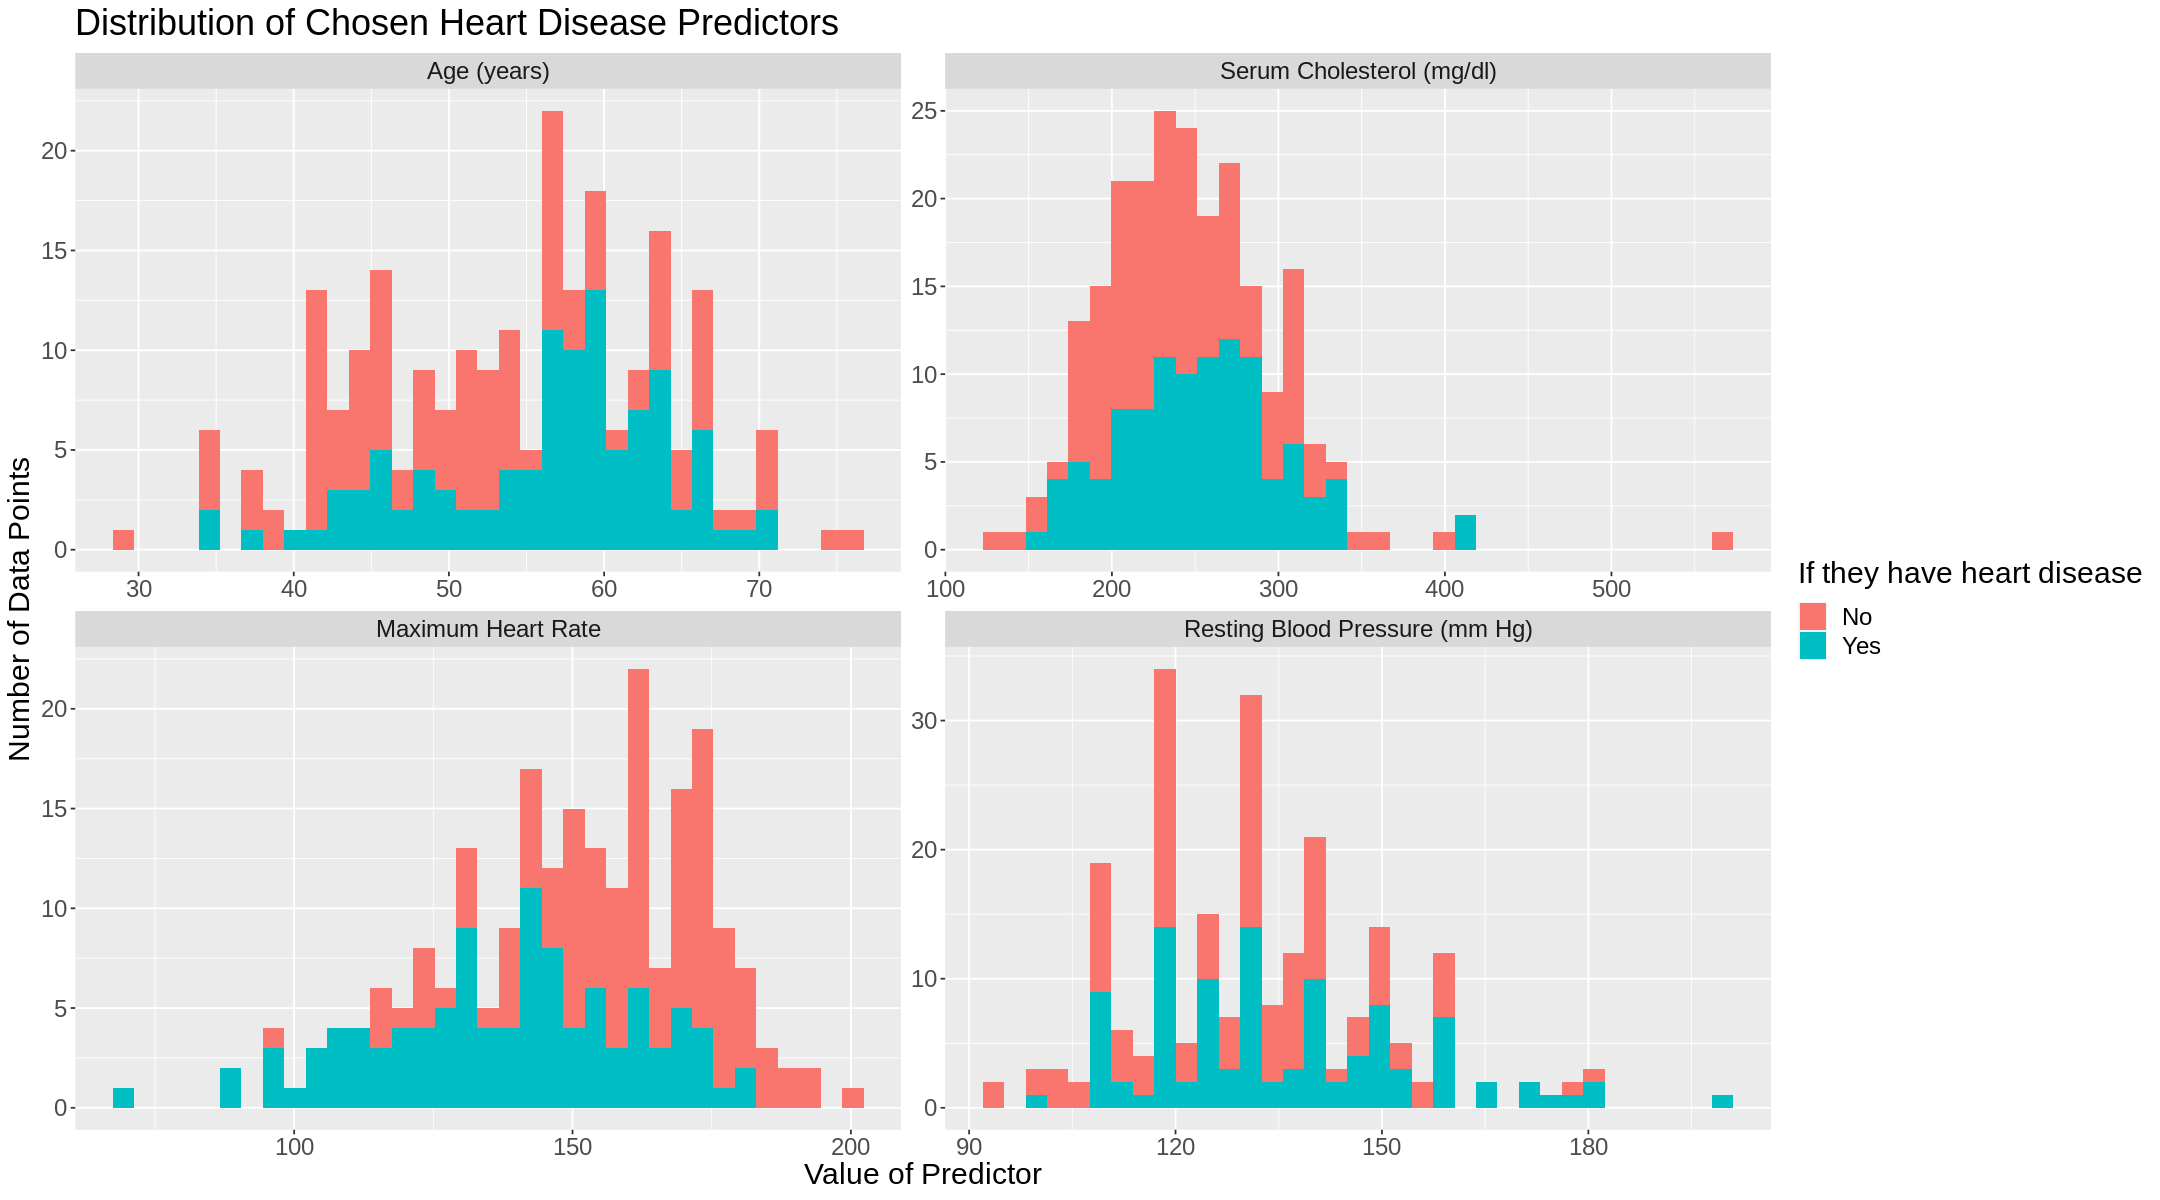

In [5]:
options(repr.plot.width = 18, repr.plot.height = 10)

#Fix data for facet_wrap
cleveland_plot_data <- cleveland_train |> 
    pivot_longer(cols = age:thalach, names_to = "parameter", values_to = "value")

#Facet Labels
parameter.labs <- c("Age (years)", "Serum Cholesterol (mg/dl)", "Maximum Heart Rate", "Resting Blood Pressure (mm Hg)")
names(parameter.labs) <- c("age", "chol", "thalach", "trestbps")

#Plot
cleveland_plot <- ggplot(cleveland_plot_data, aes(x=value, fill = if_hd)) +
    geom_histogram(bins=35) +
    facet_wrap(parameter ~ . ,scales = "free", labeller = labeller(parameter = parameter.labs)) +
    labs(x= "Value of Predictor", y="Number of Data Points", age= "age (years)", fill = "If they have heart disease") +
    ggtitle("Distribution of Chosen Heart Disease Predictors") +
    theme(text = element_text(size=18))

cleveland_plot

# ***Methods***

We will perform a classification analysis with `processed.cleveland.data`, using `age`, `thalach`, `trestbps`, and `chol` to predict `if_hd`. While these predictors are numeric, we may also try to incorporate some categorical variables in our predictors, such as `sex` and `fbs`, as they might give us better insights into identifying the class. Since those two variables are already represented as binary, knn can factor them in when measuring the distance between neighbours.

Over the course of our analysis, we will divide the data into training and testing sets. After creating a model using the training data, we will visualize our model using a confusion matrix to see how well our model predicts against the testing set.

# ***Expected outcomes and significance***

We anticipate that people who are older (`age`) will have higher rates of heart disease than those who are younger (due to aging). The maximum heart rate achieved (`thalach`) represents how much stress your heart can undergo and relates to the fitness one has. Therefore, we also believe that a lower `thalach` will correlate to heart disease. Furthermore, we presume that those with higher `trestbps` (resting blood pressure) and `chol` (cholesterol) levels will show more heart disease diagnoses; These are factors known to directly impact your heart health by decreasing the flow of blood and oxygen to your heart, and by blocking your arteries. Using these predictors, we think that our model will predict the categorical class well.

These findings will give us insight on what correlates to heart 
disease, therefore, it may personally influence us to try to reduce our association 
with the factors contributing to it. 

Furthermore, our findings will lead us to more questions… 
Are these traits genetic? At what age is heart disease most prevalent? The impact of gender 
for heart disease? 